<img heigth="8" src="https://i.imgur.com/BhG5KQ3.png" alt="pbs-enae">

<h1 align="left">¿Como es un proyecto de Machine Learning de pricinpio a fin?</h1>

<h2 align="left"><i>Traffic Congestion Prediction</i></h2>

<p align="left">
  <h3>Joseph F. Vergel-Becerra | Machine Learning - Tools and Skill Courses</h3>
  <br>
  <b>Last updated:</b> <i>07/02/2023</i>
  <br><br>
  <a href="#tabla-de-contenido">Tabla de contenido</a> •
  <a href="#referencias">Referencias</a> •
  <a href="#contribuir">Contribuir</a> •
  <a href="#agradecimientos">Agradecimientos</a>
  <br><br>
</p>
<table align="left">
  <td>
      <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
        <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
      </a>
  </td>
  <td>
    <a href="https://colab.research.google.com/github/joefavergel/pbs-enae-ml-course/blob/main/traffic_congestion_end-to-end_ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
      </a>
  </td>
  <td>
    <a href="https://github.com/joefavergel/pbs-enae-ml-course" target="_parent"><img src="https://img.shields.io/github/forks/joefavergel/pbs-enae-ml-course?style=social" alt="Fork"/>
      </a>
  </td>
</table>
<br>
<br>

---

Optimizar el tiempo de entrega al maximo, es uno de los principales objetivos que las empresas logistica de ultima milla definen como crucial en sus operaciones. Ahora bien, imagina que te acaban de contratar en el equipo de ciencia de datos de una de estas compañias y tu primer reto es ***\"optimizar las rutas y entregas para que tomen el menor tiempo posible\"***. Para ello cuentas con datos referentes a la congestion del trafico en las ciudades en las que la empresa opera y debes diseñar e implementar una prueba de concepto (PoC del ingles *Proof-of-Concept*) que agregue valor a la compañia.

<a id='tabla-de-contenido'></a>
## Tabla de contenido
    
<ol>
    <li><a href="#definiendo-el-problema"><b>Definiendo el problema y los objetivos</b></a></li>
    <li><a href="#trabajando-con-datos"><b>Trabajando con datos reales y una mirada general</b></a></li>
    <ol>
        <li>Enmarcar el problema</li>
        <li>Seleccionar una medida de rendimiento</li>
        <li>Validar las suposiciones</li>
    </ol>
    <li><a href="#descubra-y-visualice"><b>Descubra y visualice los datos para obtener información</b></a></li>
    <ol>
        <li>Buscando correlaciones</li>
        <li>Ponga su experticia combinando atributos</li>
    </ol>
    <li><a href="#preprocesamiento-e-ingenieria"><b>Preprocesamiento e ingeniería de características</b></a></li>
    <ol>
        <li>Limpieza e imputación</li>
        <li>Transformación</li>
        <li>Escalado</li>
        <li>Selección</li>
    </ol>
    <li><a href="#entrenamiento-de-modelos"><b>Entrenamiento de modelos</b></a></li>
    <ol>
        <li><i>No free lunch theorem</i></li>
        <li>Entrenamiento</li>
        <li>Evaluación y selección</li>
        <li>Selección</li>
    </ol>
    <li><a href="#fine-tuning-y-optimizacion"><b>Fine-tuning y optimización de hiperparametros</b></a></li>
    <li><a href="#puesta-en-producción"><b>Puesta en producción</b></a></li>
    <ol>
        <li><i>Exportar el modelo</i></li>
        <li>Entrenamiento</li>
        <li>Prueba de concepto</li>
        <li>Limitaciones</li>
    </ol>
</ol>

In [1]:
import sys
from IPython.core.display import HTML

from pathlib import Path
from packaging import version
import sklearn
import urllib.request

try:
    import google.colab
    RENDER = "colab"
    print("[INFO] Notebook running in Colab!")
except:
    RENDER = None


print("[INFO] Este proyecto requiere python 3.8 o superior y Scikit-Learn 1.0.1 o superior.")
assert sys.version_info >= (3, 8)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
print("[INFO] Versiones vificadas exitosamente!")


def css_styling():
    styles_path = Path(f"./styles/custom.css")
    if not styles_path.is_file():
        Path("styles").mkdir(parents=True, exist_ok=True)
        url = f"https://github.com/joefavergel/pbs-enae-ml-course/blob/main/styles/custom.css?raw=true"
        urllib.request.urlretrieve(url, styles_path)

    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)


css_styling()

[INFO] Este proyecto requiere python 3.8 o superior y Scikit-Learn 1.0.1 o superior.
[INFO] Versiones vificadas exitosamente!


<a id='definiendo-el-problema'></a>
## 1. Definiendo el problema y los objetivos

Es comun que los objetivos que trazan los [C levels](https://academia.crandi.com/negocios-digitales/ejecutivos-c-level/) de las compañias, son definidos en terminos de la planeacion estrategica y los objetivos de negocio de sus respectivas divisiones. Nuestro caso no es la excepción, pues ***\"Optimizar las rutas y entregas para que tomen el menor tiempo posible\"***, seguramente requerirá más de una solución basada en datos y no existirá un único modelo "mágico" que lo consiga con alta precisión. No obstante, un muy buen primer paso dentro de la etapa de **entendimiento del negocio**, es plantear una hipótesis referente a  analizar lo que la intuición y el sentido común nos sugieren. Es por esto que se puede pensar que:
<br><br>

<div class=hypo>
<b>Hipótesis 1:</b> La congestión del tráfico en las ciudades de operación, es posiblemente la principal causa de retrasos en las entregas.
</div><br><br>

<a id="trabajando-con-datos"></a>
## 2.2. Trabajando con datos reales y una mirada general

El proyecto inició hace un par de meses y en tu tarea de empalme, solo recibiste la información recolectada. Los datos proporcionados consisten de **métricas de registros de viajes agregados**, para varias flotas de vehículos comerciales de tipo semirremolque. La Fig. 1 muestra la metodología de recolección de datos del proveedor.

<p align="center">
  <a target="_blank">
    <img width="400px" src="https://assets-global.website-files.com/5f2a93fe880654a977c51043/60ca13eef83c460f414f849a_image6.gif" alt="intersection-ai">
  </a><br>
  <b>Figura 1:</b> Análisis de detección de objetos y segmentación de una cámara aérea, para una de las intersecciones viales proporcionada por el proveedor de los datos¹.
</p>

Ahora bien, al ser un problema de ***big data²***, el proveedor **agrupó por los datos intersección vial, mes, hora del día, dirección conducida a través de la intersección y si el día fue fin de semana o no**. Dentro de la poca documentación que entregó el anterior científico de datos, se encontró en un `README.md` la siguiente nota con respecto a la agregación de los datos:

> *Bajo nuestro diseño y por solicitud nuestra, se le solicitó al proveedor de los datos la información de tres cuantiles diferentes, de dos métricas diferentes, que cubren cuánto tiempo le tomó al grupo de vehículos atravesar la intersección. Específicamente, los percentiles 20, 50 y 80 para el tiempo total detenido en una intersección `TotalTimeStopped` y la distancia entre la intersección y el primer lugar donde se detuvo un vehículo mientras esperaba `DistanceToFirstStop`.³*

Sabiendo esto, el primer paso es dar un vistazo a los datos. A continuación, la siguiente celda verifica la existencia del archivo original de datos y si no ha sido descargado, creará el directorio, descargará el archivo y lo descomprimirá.

---

¹ <a href="https://www.mapbox.com/blog/300-more-lane-guidance-for-navigation-powered-by-ai-mapping">mapbox: 300% More Lane Guidance For Navigation Powered By Ai Mapping</a>.<br>
² Ver <a href="#ejercicios-22">Ejercicio 1</a>.<br>
³ Ver <a href="#ejercicios-22">Ejercicio 2</a>.

In [2]:
from pathlib import Path
from zipfile import ZipFile
import urllib.request

DATASET = "bigquery-geotab-intersection-congestion"
DATA_PATH = f"datasets/{DATASET}/"


def load_traffic_congestion_data(dataset: str):
    zipfile_path = Path(f"datasets/{dataset}.zip")
    if not zipfile_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = f"https://github.com/joefavergel/datasets/blob/main/{dataset}.zip?raw=true"
        urllib.request.urlretrieve(url, zipfile_path)
    Path(f"datasets/{dataset}").mkdir(parents=True, exist_ok=True)
    try:
        ZipFile(zipfile_path).extractall(f"datasets/{dataset}")
        print(f"[INFO] Dataset \'{dataset}\' downloaded and uncompressed correctly!")
    except Exception as e:
        print(f"[Exception] There's been a problem: {e}")


load_traffic_congestion_data(dataset=DATASET)

[INFO] Dataset 'bigquery-geotab-intersection-congestion' downloaded and uncompressed correctly!


Disponiendo de la información, utilicemos la biblioteca [pandas](https://pandas.pydata.org/) para manipularla y analizarla.

> *\"pandas es una herramienta de análisis y manipulación de datos de código abierto rápida, potente, flexible y fácil de usar, construida sobre el lenguaje de programación Python\"*.

In [3]:
import os

import pandas as pd

train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f"[INFO] Training dataset dimnesions (rows, cols): {train.shape}")
    display(train.head())
    
    print(f"\n[INFO] testing dataset dimnesions (rows, cols): {test.shape}")
    display(test.head())

[INFO] Training dataset dimnesions (rows, cols): (856387, 28)


,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,6,Marietta Boulevard Northwest_NW_Marietta Boule...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,6,Marietta Boulevard Northwest_SE_Marietta Boule...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,6,Marietta Boulevard Northwest_NW_Marietta Boule...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,6,Marietta Boulevard Northwest_SE_Marietta Boule...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,6,Marietta Boulevard Northwest_NW_Marietta Boule...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta



[INFO] testing dataset dimnesions (rows, cols): (1921357, 13)


,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,City
0,0,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,0,0,6,Peachtree Street Southwest_NE_Peachtree Street...,Atlanta
1,1,1,33.75094,-84.393032,Peachtree Street Southwest,Mitchell Street Southwest,SW,SE,0,0,6,Peachtree Street Southwest_SW_Mitchell Street ...,Atlanta
2,2,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,0,0,6,Peachtree Street Southwest_SW_Peachtree Street...,Atlanta
3,3,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,1,0,6,Peachtree Street Southwest_NE_Peachtree Street...,Atlanta
4,4,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,1,0,6,Peachtree Street Southwest_SW_Peachtree Street...,Atlanta


Analicemos las características generales de los *[dataframes](https://pandas.pydata.org/docs/user_guide/dsintro.html#dataframe)* de entrenamiento `train` y de pruebas `test`.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856387 entries, 0 to 856386
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RowId                    856387 non-null  int64  
 1   IntersectionId           856387 non-null  int64  
 2   Latitude                 856387 non-null  float64
 3   Longitude                856387 non-null  float64
 4   EntryStreetName          848239 non-null  object 
 5   ExitStreetName           850100 non-null  object 
 6   EntryHeading             856387 non-null  object 
 7   ExitHeading              856387 non-null  object 
 8   Hour                     856387 non-null  int64  
 9   Weekend                  856387 non-null  int64  
 10  Month                    856387 non-null  int64  
 11  Path                     856387 non-null  object 
 12  TotalTimeStopped_p20     856387 non-null  float64
 13  TotalTimeStopped_p40     856387 non-null  float64
 14  Tota

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921357 entries, 0 to 1921356
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   RowId            int64  
 1   IntersectionId   int64  
 2   Latitude         float64
 3   Longitude        float64
 4   EntryStreetName  object 
 5   ExitStreetName   object 
 6   EntryHeading     object 
 7   ExitHeading      object 
 8   Hour             int64  
 9   Weekend          int64  
 10  Month            int64  
 11  Path             object 
 12  City             object 
dtypes: float64(2), int64(5), object(6)
memory usage: 190.6+ MB


In [6]:
train.describe()

,RowId,IntersectionId,Latitude,Longitude,Hour,Weekend,Month,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,...,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80
count,8.563870e+05,856387.000000,856387.000000,856387.000000,856387.000000,856387.000000,856387.000000,856387.000000,856387.000000,856387.000000,...,856387.000000,856387.000000,856387.000000,856387.000000,856387.000000,856387.000000,856387.000000,856387.000000,856387.00000,856387.000000
mean,2.349550e+06,833.283384,39.618965,-77.916488,12.431234,0.277880,9.104808,1.755596,5.403592,7.722655,...,3.181096,9.162174,12.722165,18.926085,34.201656,6.765856,20.285128,28.837113,44.27231,83.991313
std,2.472178e+05,654.308913,2.935437,5.952959,6.071843,0.447954,1.991094,7.146549,12.981674,15.685910,...,11.835994,20.446568,24.219271,29.851797,41.130668,29.535968,59.202108,75.217343,102.03225,160.709797
min,1.921357e+06,0.000000,33.649973,-87.862288,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.135454e+06,291.000000,39.936739,-84.387607,8.000000,0.000000,7.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,2.349550e+06,679.000000,39.982974,-75.175055,13.000000,0.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.00000,60.400000
75%,2.563646e+06,1264.000000,41.910047,-75.100495,17.000000,1.000000,11.000000,0.000000,0.000000,10.000000,...,0.000000,0.000000,22.000000,31.000000,49.000000,0.000000,0.000000,53.100000,64.20000,85.950000
max,2.777743e+06,2875.000000,42.381782,-71.025550,23.000000,1.000000,12.000000,298.000000,375.000000,375.000000,...,337.000000,356.000000,356.000000,357.000000,359.000000,1901.900000,2844.400000,2851.100000,3282.40000,4079.200000


In [7]:
test.describe()

,RowId,IntersectionId,Latitude,Longitude,Hour,Weekend,Month
count,1.921357e+06,1.921357e+06,1.921357e+06,1.921357e+06,1.921357e+06,1.921357e+06,1.921357e+06
mean,9.606780e+05,8.375807e+02,3.967647e+01,-7.787487e+01,1.242410e+01,2.713171e-01,9.099713e+00
std,5.546481e+05,6.474817e+02,2.915613e+00,5.973443e+00,5.997195e+00,4.446394e-01,1.993396e+00
min,0.000000e+00,0.000000e+00,3.364997e+01,-8.789715e+01,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.803390e+05,3.000000e+02,3.993964e+01,-8.438431e+01,8.000000e+00,0.000000e+00,7.000000e+00
50%,9.606780e+05,6.850000e+02,4.001254e+01,-7.517135e+01,1.200000e+01,0.000000e+00,9.000000e+00
75%,1.441017e+06,1.257000e+03,4.194657e+01,-7.504245e+01,1.700000e+01,1.000000e+00,1.100000e+01
max,1.921356e+06,2.875000e+03,4.240692e+01,-7.099715e+01,2.300000e+01,1.000000e+00,1.200000e+01


In [8]:
train.isnull().sum()

RowId                         0
IntersectionId                0
Latitude                      0
Longitude                     0
EntryStreetName            8148
ExitStreetName             6287
EntryHeading                  0
ExitHeading                   0
Hour                          0
Weekend                       0
Month                         0
Path                          0
TotalTimeStopped_p20          0
TotalTimeStopped_p40          0
TotalTimeStopped_p50          0
TotalTimeStopped_p60          0
TotalTimeStopped_p80          0
TimeFromFirstStop_p20         0
TimeFromFirstStop_p40         0
TimeFromFirstStop_p50         0
TimeFromFirstStop_p60         0
TimeFromFirstStop_p80         0
DistanceToFirstStop_p20       0
DistanceToFirstStop_p40       0
DistanceToFirstStop_p50       0
DistanceToFirstStop_p60       0
DistanceToFirstStop_p80       0
City                          0
dtype: int64

In [9]:
test.isnull().sum()

RowId                  0
IntersectionId         0
Latitude               0
Longitude              0
EntryStreetName    19198
ExitStreetName     15587
EntryHeading           0
ExitHeading            0
Hour                   0
Weekend                0
Month                  0
Path                   0
City                   0
dtype: int64

A continuación, identifiquemos cuales son las variables categóricas y las variables numéricas de *dataset*. Para esto podemos usar el metodo [`pandas.DataFrame.select_dtypes()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html#pandas-dataframe-select-dtypes) y extraer los nombres de las columnas.

In [10]:
cols = train.columns
num_cols = list(train.select_dtypes(include=["int", "float"]).columns)
print("[INFO] Numerical features: ", num_cols)
cat_cols = list(train.select_dtypes(include=["object"]).columns)
print("\n[INFO] Categorical features:", cat_cols)

[INFO] Numerical features:  ['RowId', 'IntersectionId', 'Latitude', 'Longitude', 'Hour', 'Weekend', 'Month', 'TotalTimeStopped_p20', 'TotalTimeStopped_p40', 'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80', 'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40', 'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60', 'TimeFromFirstStop_p80', 'DistanceToFirstStop_p20', 'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50', 'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80']

[INFO] Categorical features: ['EntryStreetName', 'ExitStreetName', 'EntryHeading', 'ExitHeading', 'Path', 'City']


In [11]:
cities = list(train["City"].unique())
print("[INFO] Cities:", cities)
print("[INFO] Data by city:\n\n", train['City'].value_counts())

[INFO] Cities: ['Atlanta', 'Boston', 'Chicago', 'Philadelphia']
[INFO] Data by city:

 Philadelphia    390237
Boston          178617
Atlanta         156484
Chicago         131049
Name: City, dtype: int64


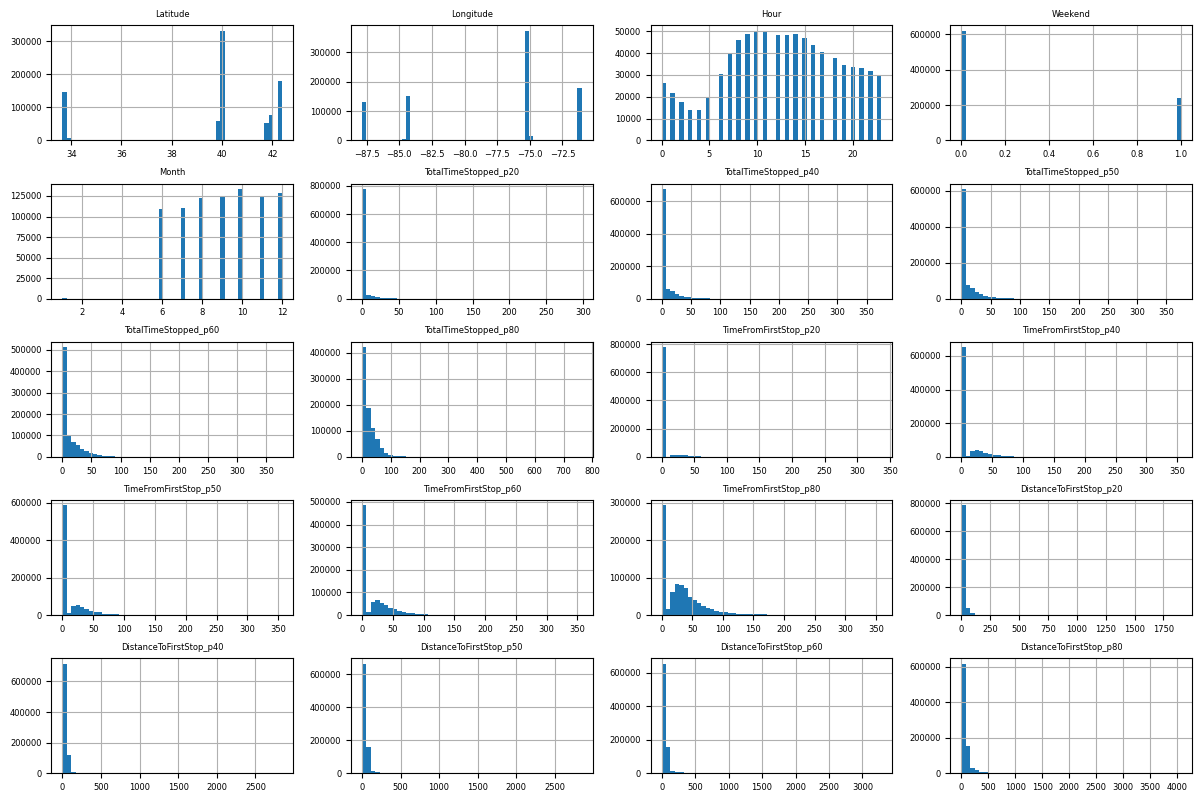

In [12]:
import matplotlib.pyplot as plt

plt.rc('font', size=6)
plt.rc('axes', labelsize=6, titlesize=6)
plt.rc('legend', fontsize=6)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)
train.drop(["RowId", "IntersectionId"], axis=1).hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [13]:
train_intersection_ids = set(train["IntersectionId"].value_counts().index)
print("[INFO] Number of unique intersections in training dataset: ", len(train_intersection_ids))
test_intersection_ids = set(test["IntersectionId"].value_counts().index)
print("[INFO] Number of unique intersections in testing dataset: ", len(test_intersection_ids))
print("[INFO] Number of commun intersections: ",
    len(set.intersection(
        train_intersection_ids,
        test_intersection_ids
    ))
)
test_inter_minus_train_inter = test_intersection_ids - train_intersection_ids
print(
    "[INFO] Number of intersections that are in the "
    "testing set but not in the training set: ",
    len(test_inter_minus_train_inter)
)
train_inter_minus_test_inter = train_intersection_ids - test_intersection_ids
print(
    "[INFO] Number of intersections that are in the training"
    "set but not in the testing set: ",
    len(train_inter_minus_test_inter)
)
alpha = len(test_inter_minus_train_inter) / len(train_inter_minus_test_inter)
print("[INFO] Proportionality factor between the two differences: ", round(alpha, 2))

[INFO] Number of unique intersections in training dataset:  2559
[INFO] Number of unique intersections in testing dataset:  2765
[INFO] Number of commun intersections:  2485
[INFO] Number of intersections that are in the testing set but not in the training set:  280
[INFO] Number of intersections that are in the trainingset but not in the testing set:  74
[INFO] Proportionality factor between the two differences:  3.78


<div class="warn">
<b>Advertencia:</b> Si el conjunto $A := test\_intersection\_ids \Rightarrow A-B = 280$, i.e. que la diferencia entre el conjunto de intersecciones viales en testo y el conjunto de intersecciones viales en entrenamiento, corresponden al área azul. Por consiguiente, el numero de intersecciones viales que estan en el conjunto de testeo y que no estan el conjunto de entrenamiento, es 3.78 veces mas que su contraparte, i.e., el número de intersecciones viales que están en el conjunto de entrenamiento pero que no están en el conjunto de testeo (74 intersecciones viales en este último escenario). Esto es un claro ejemplo de lo que se conoce como *dataset shift* o discrepancia en los datos.
</div>

<p align="center">
  <a target="_blank">
    <img width="400px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/SetDifferenceA.svg/663px-SetDifferenceA.svg.png" alt="a-b">
  </a><br>
  <b>Figura 2:</b> Diagrama de Venn de la operacion de conjuntos A-B.
</p>


---

³ <a href="https://www.seldon.io/what-is-covariate-shift">Seldon: What is covariate shift in machine learning?</a>.<br>

In [14]:
# new_intersections = test.query("IntersectionId in @test_inter_minus_train_inter", engine="python")

In [15]:
#Converting the co-ordinates to something that bokeh likes
def merc(Coords):
    lat = Coords[0]
    lon = Coords[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [16]:
import math

In [17]:
train['Location'] = tuple(zip(train['Latitude'], train['Longitude']))
train['coords_x'] = train['Location'].apply(lambda x: merc(x)[0])
train['coords_y'] = train['Location'].apply(lambda x: merc(x)[1])
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,Location,coords_x,coords_y
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,"(33.791658500000004, -84.4300325)",-9.398708e+06,4.000861e+06
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,"(33.791658500000004, -84.4300325)",-9.398708e+06,4.000861e+06
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,"(33.791658500000004, -84.4300325)",-9.398708e+06,4.000861e+06
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,"(33.791658500000004, -84.4300325)",-9.398708e+06,4.000861e+06
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta,"(33.791658500000004, -84.4300325)",-9.398708e+06,4.000861e+06


In [18]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

init_notebook_mode(connected=True) 


def plot_georeferenced_target(
    target: str,
    city: str = 'Boston',
    dataframe: pd.DataFrame = train,
):
    grouped_target = train.groupby(
        ['City','Latitude','Longitude']
    )[target].mean().reset_index()
    fig = px.scatter_mapbox(
        grouped_target[grouped_target["City"] == city], 
        lat="Latitude",
        lon="Longitude",
        size=target,
        size_max=12,
        color=target, 
        color_continuous_scale=px.colors.sequential.Inferno,
        zoom=11,
        title=f"{target} for {city}"
    )

    fig.update_layout(mapbox_style="stamen-terrain")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    
    fig.show(render=RENDER)

In [19]:
for city in cities:
    plot_georeferenced_target(
        target='TotalTimeStopped_p80',
        city=city,
        dataframe=train,
    )

<a id="ejercicios-22"><a>
## 2.2. Ejercicios

<ol>
    <li>Defina de manera concisa, ¿Cuanta data es <i>"big data"</i>?.</li>
    <li>Explique la nota del antiguo cientifico de datos, describiendo brevemente el procedimiento que tuvo que efectuar el proveedor para cumplir con el requerimiento de "nuestra compañia".</li>
    <li>Deseo conocer el numero de muestras asociadas a cada interseccion. Procese el dataframe para obtener dicho resultado de la forma mas optima.</li>
</ol>

<a id='referencias'></a>
## Referencias

[1] Halswanter, T. (2016). *An Introduction to Statistics with Python: With Applications in the Life Sciences.* Springer.

[2] VanderPlas, J. (2016). *Python data science handbook: Essential tools for working with data.* " O'Reilly Media, Inc.".

[3] Géron, A. (2022). *Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow.* " O'Reilly Media, Inc.".

<a id='contribuir'></a>
## Contribuir

<p>Para correcciones, <i>bugs</i> o sugerencias, por favor escribe a <a href="mailto:joseph@guane.com.co">info@joefaver.dev</a> o directamente en el repositorio.</p>

<a id='agradecimientos'></a>
## Agradecimientos